# GENERATIVE ADVERSARIAL NETWORK (GAN for Fasion MNIST)
author: marvin sachio

Fashion MNIST is a dataset of 70000 grayscale images, each of size 28x28 pixels, showing various fashion items, here the challenge that i personally pick is not images classification but Generative adversarial network, for generating images from that could compete the real images from the Fashion MNIST data.

A Generative Adversarial Network (GAN) consists of two main components: a Generator and a Discriminator. These two models are trained simultaneously in a competitive process, where the Generator tries to create realistic data, and the Discriminator tries to distinguish between real and fake data. The end goal is for the Generator to produce data that is indistinguishable from real data.

## 1. importing necessary libraries
numpy for numerical computations.

gzip for handling compressed files.

pandas for data manipulation.

matplotlib.pyplot for data visualization.

tensorflow for building and training neural networks.

In [1]:
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

2024-08-22 05:35:32.075305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 05:35:32.075440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 05:35:32.210235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Loading and Scaling

this part of the notebook gonna read the data from the kaggle local, this process can be shorten by using tensorflow built-in dataset for fashion MNIST. 

the main point of this code is to load the data and extract the data, then the data are being scaled if the user want to scaled the data or not, then the data are loaded and showing the shape of the data from the label and the images dataset.

In [2]:
def read_mnist_images(filepath, class_labels=None, scale=True):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')

        # Read image data
        raw_data = f.read()
        images = np.frombuffer(raw_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)
        
        # Scale images to range [-1, 1]
        if scale:
            images = (images - 127.5) / 127.5

        return images

def read_mnist_labels(filepath, class_labels=None):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')

        # Read label data
        raw_data = f.read()
        labels = np.frombuffer(raw_data, dtype=np.uint8)
        return labels
    
# load n scale the images
train_images = read_mnist_images('/kaggle/input/fashionmnist/t10k-images-idx3-ubyte')
train_labels = read_mnist_labels('/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte')
test_images = read_mnist_images('/kaggle/input/fashionmnist/t10k-images-idx3-ubyte')
test_labels = read_mnist_labels('/kaggle/input/fashionmnist/train-labels-idx1-ubyte')


# Print shape of the data
print("Train images shape (scaled):", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape (scaled):", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape (scaled): (10000, 28, 28)
Train labels shape: (10000,)
Test images shape (scaled): (10000, 28, 28)
Test labels shape: (60000,)


here i go for plotting one of the images to see how the images and the label would be like

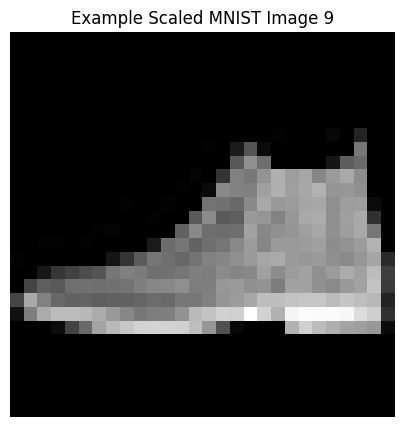

In [3]:
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0], cmap='gray')
plt.title(f'Example Scaled MNIST Image {train_labels[0]}')
plt.axis('off')
plt.show()

## 3. Creating GAN Model 

The Generator takes in random noise (usually sampled from a standard normal distribution) and transforms it into a data sample that resembles the real dataset (in this case, images similar to the MNIST dataset). The architecture of the Generator typically consists of layers designed to upsample and refine the noise into a meaningful output

The Discriminator's role is to take an image as input and output a probability that indicates whether the image is real (from the dataset) or fake (generated by the Generator). The architecture typically involves convolutional layers that downsample the input image and extract features.

In [4]:
# Generator and discriminator models
generator = models.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

discriminator = models.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### Generator explanation:
Dense Layer: This fully connected layer expands the input noise vector (100-dimensional) into a larger vector (7x7x256). The output is reshaped into a 3D tensor to resemble a small image.

BatchNormalization: This layer normalizes the inputs to have zero mean and unit variance, which helps stabilize and accelerate the training process.

LeakyReLU Activation: A type of activation function that allows a small, non-zero gradient when the unit is not active, which prevents the “dying ReLU” problem.

Reshape Layer: Converts the output from the dense layer into a 3D tensor with dimensions (7, 7, 256), mimicking the shape of an image.

Conv2DTranspose Layers: Also known as deconvolutional layers, these are used to upsample the image, gradually increasing its size from 7x7 to 28x28 pixels. These layers also refine the image by applying filters.

Tanh Activation: The final layer uses the tanh activation function, which outputs values in the range [-1, 1]. This range matches the scaled values of the MNIST images.

### Discriminator explanation:
Conv2D Layers: These layers apply convolutional filters to the input image, extracting features while downsampling the image size. The stride of 2 and padding ensure the image dimensions are reduced by half in each layer.

LeakyReLU Activation: As in the Generator, this activation function allows the Discriminator to learn from negative values, which is crucial for effective training.

Dropout Layer: This layer randomly drops a fraction of the input units during training, which helps prevent overfitting by forcing the network to learn more robust features.

Flatten Layer: Converts the 2D output of the convolutional layers into a 1D vector, preparing it for the final dense layer.

Dense Layer: The final layer outputs a single value, representing the probability that the input image is real.

## 4. Training the model

GAN model consist of two models that area trained together in a competitive manner, so in this part are separated into some part

### 1. define loss function and optimizer
Loss Function (cross_entropy): The Binary Crossentropy loss is used to measure the difference between the predicted outputs and the actual labels. This loss function is crucial for both the Generator and the Discriminator. The from_logits=True argument indicates that the output of the Discriminator is not passed through a sigmoid activation function.

Optimizers: The Adam optimizer is used for both the Generator and Discriminator. The learning rate is set to 1e-4, which is a common choice for stabilizing GAN training.

### 2. prepare the dataset
BUFFER_SIZE and BATCH_SIZE: BUFFER_SIZE is used to shuffle the dataset, and BATCH_SIZE determines the number of images fed into the model at each training step.

noise_dim: This represents the dimensionality of the noise vector that will be input to the Generator. It is typically set to a relatively small value (e.g., 100).

seed: A fixed random noise input that is used to generate and save images at each epoch, allowing for consistent comparison of results over time.

train_dataset: The training dataset is prepared by shuffling the images and batching them. The tf.data.Dataset API is used to efficiently load and preprocess the data

### 3. define the model loss function 
discriminator_loss: This function calculates the Discriminator's loss. The Discriminator tries to maximize the difference between real images (with labels as ones) and fake images generated by the Generator (with labels as zeros). The loss is the sum of the real loss and fake loss.

generator_loss: This function calculates the Generator's loss. The Generator tries to fool the Discriminator into classifying fake images as real, so its loss is calculated by comparing the Discriminator's output on the fake images to an array of ones.

### 4. define the training step
train_step function: This function represents a single step in the training process.

Noise Generation: A batch of random noise vectors is generated, which the Generator will use to create fake images.

Gradient Tapes: TensorFlow's GradientTape is used to record operations for automatic differentiation. Two tapes are used, one for the Generator and one for the Discriminator.

Forward Pass: The Generator creates fake images from the noise, and the Discriminator evaluates both real images from the dataset and the fake images.

Loss Calculation: The loss for both models is calculated using the previously defined loss functions.

Backpropagation: The gradients of the losses with respect to the models' trainable variables are calculated and used to update the models using the Adam optimizer.

### 5. define the training loop
train function: This function manages the overall training process, iterating over multiple epochs.

Epochs: The model is trained for a specified number of epochs. During each epoch, all batches in the dataset are processed.

Save Images: Every 10 epochs, the generate_and_save_images function is called to generate images from the fixed seed and save them for visualization.

### 6. lastly we try to generate and seve images 
generate_and_save_images function: This function generates images from the Generator using the fixed noise seed.

Image Generation: The Generator creates images from the test_input noise vector.

Plotting: The images are plotted in a grid using matplotlib, and the plot is saved to a file named according to the current epoch.

### 7. train the model
The GAN is trained for 500 epochs using the train function. During training, the Generator and Discriminator continuously improve as they compete with each other.

2024-08-22 05:39:09.258068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


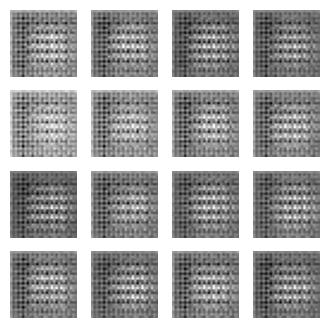

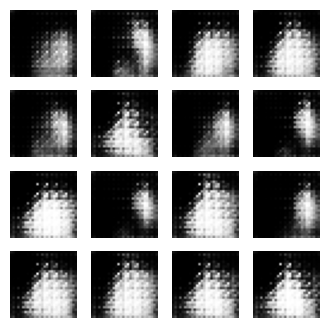

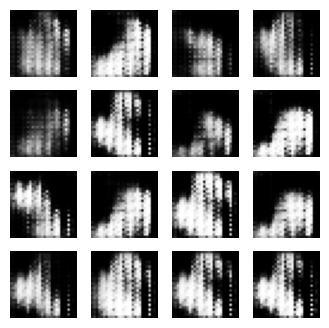

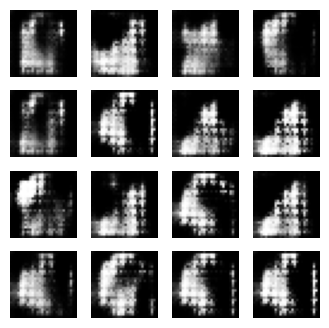

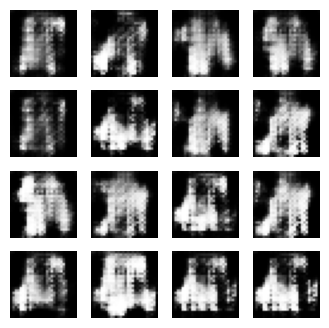

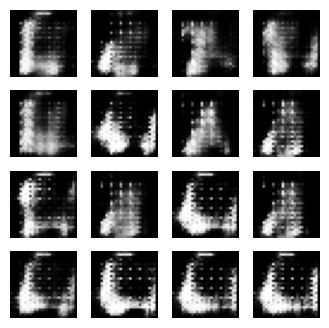

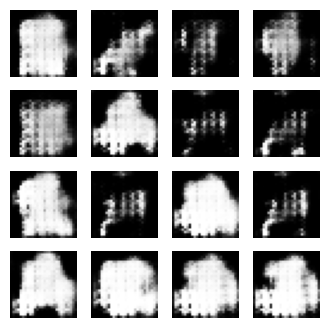

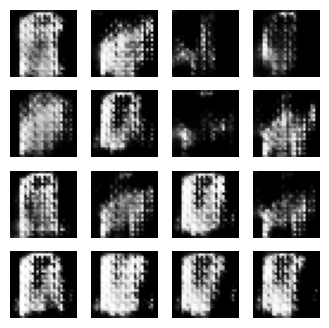

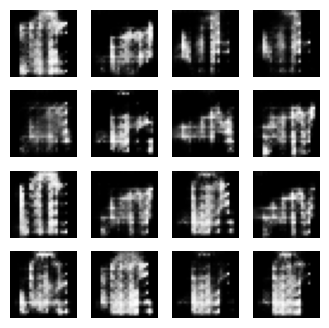

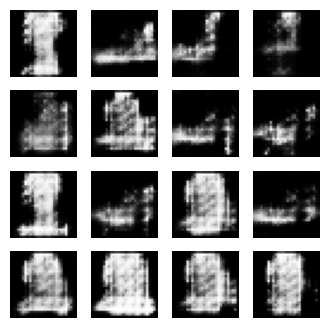

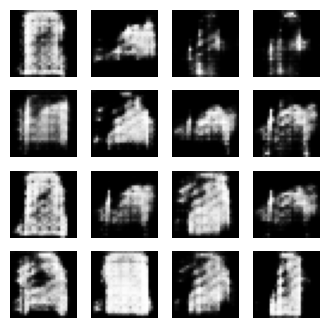

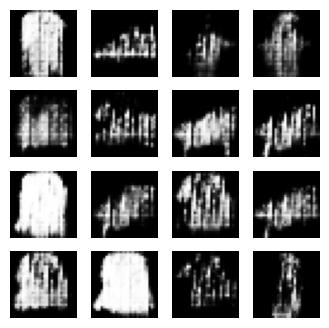

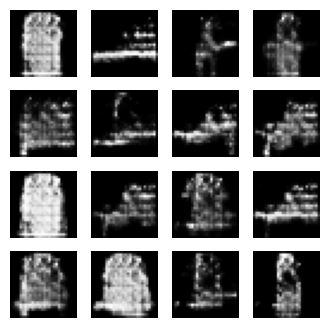

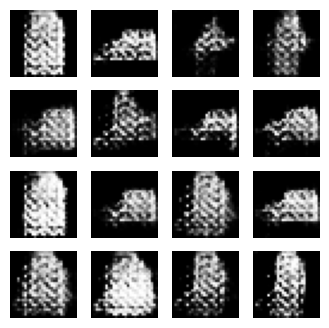

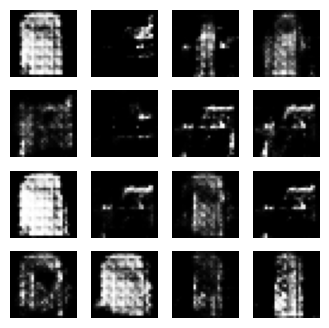

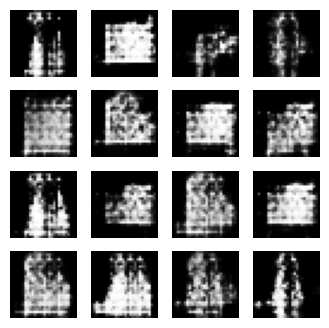

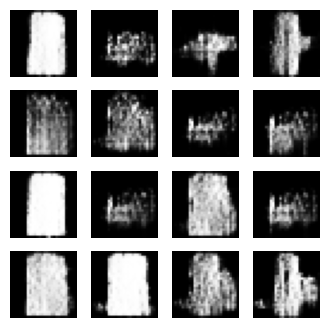

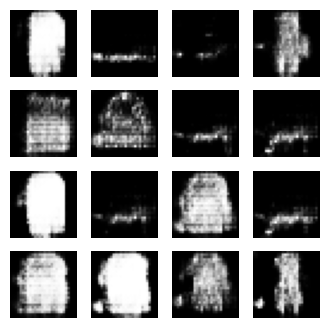

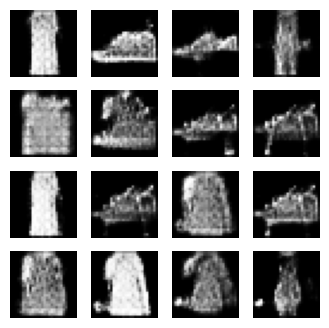

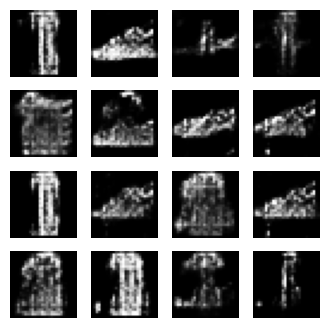

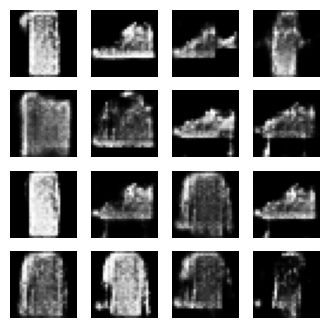

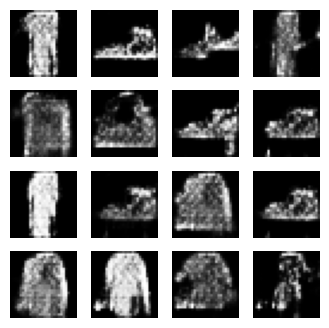

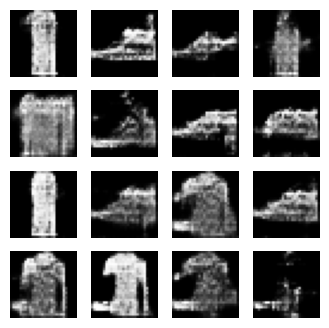

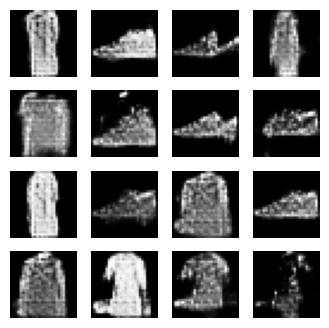

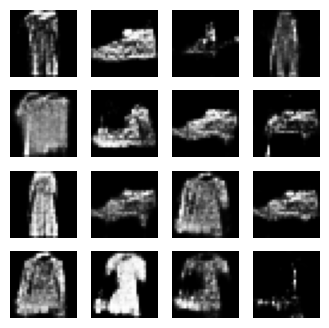

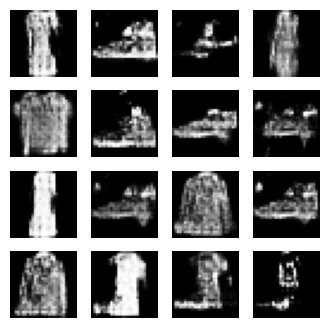

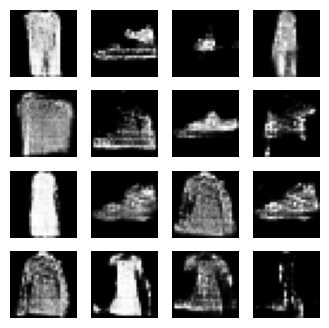

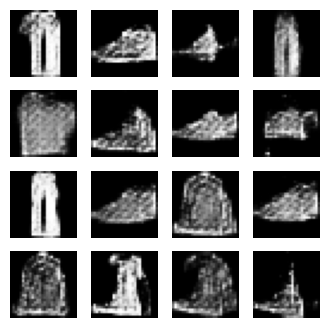

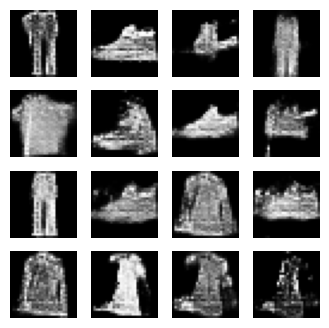

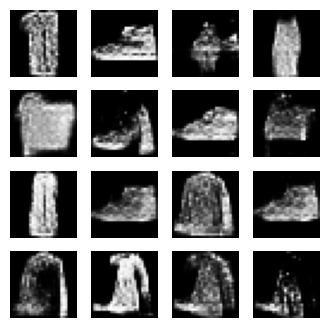

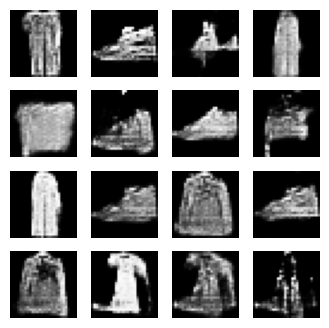

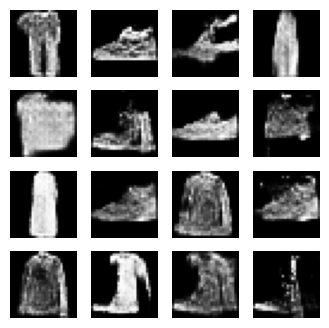

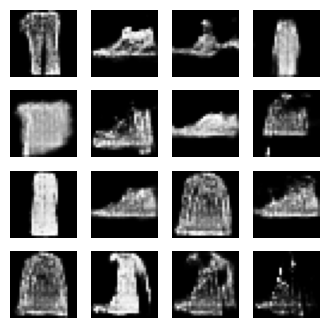

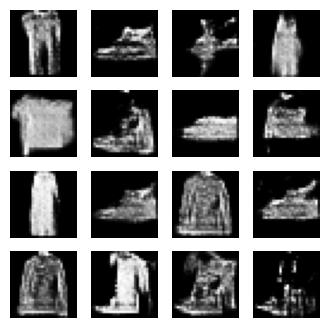

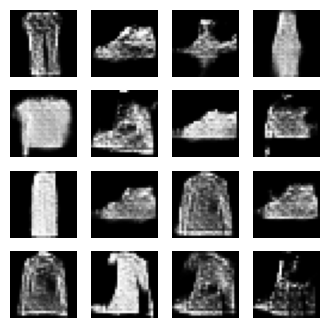

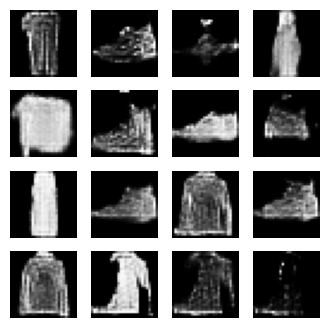

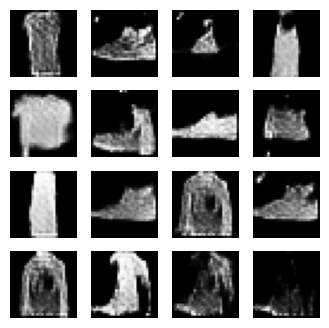

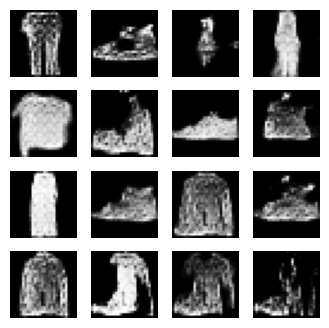

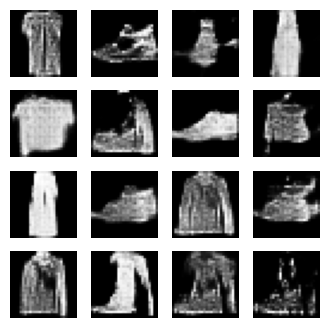

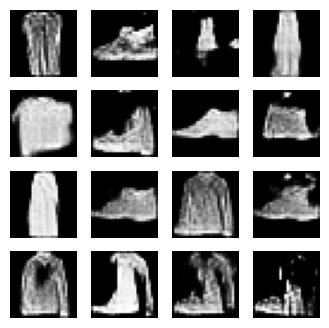

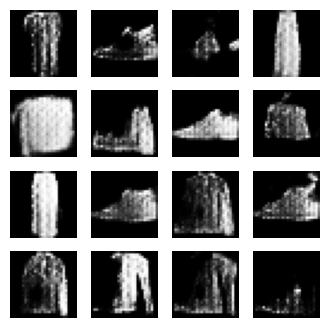

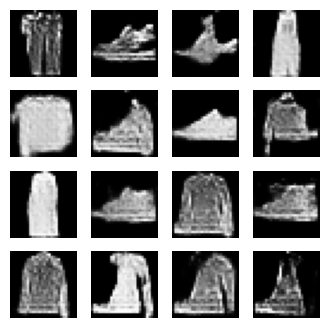

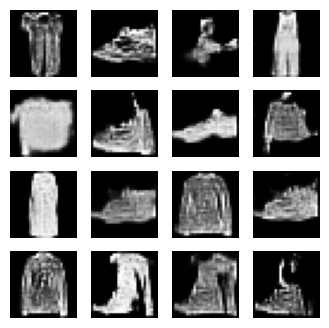

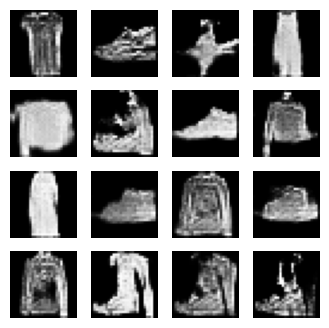

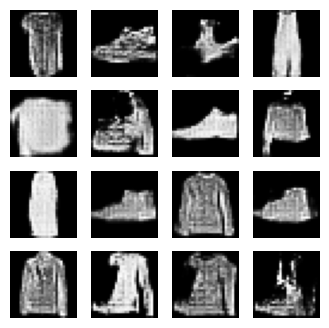

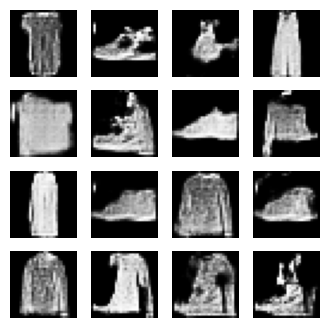

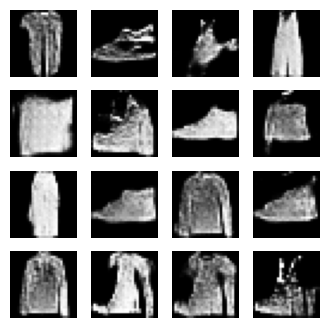

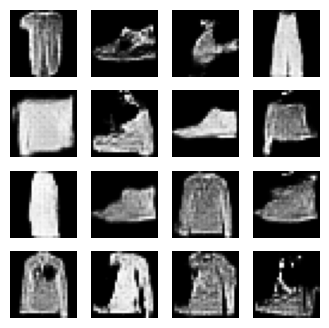

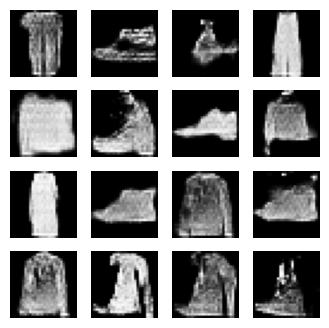

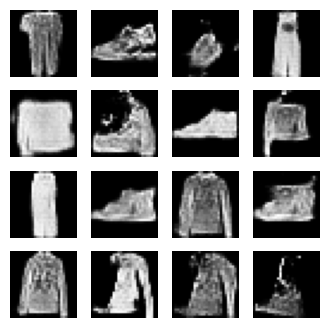

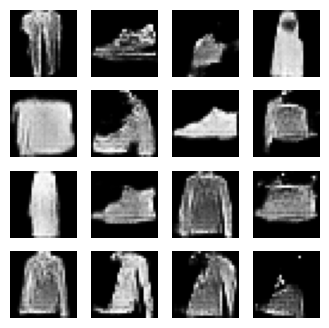

In [6]:
# Define loss function and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Prepare the dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

# Define the loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Define the training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)

# Generate and save images function
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the GAN
EPOCHS = 500
train(train_dataset, EPOCHS)

## Showing the model result 
the training process might take long time but the result might be significantly nice

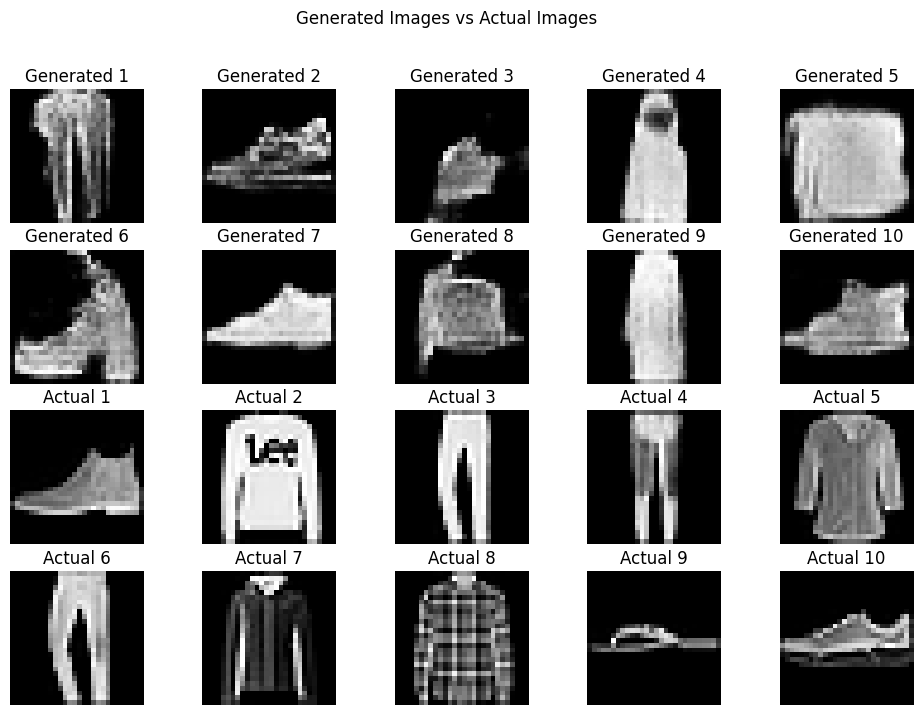

In [7]:
# Function to compare generated images with actual images
def compare_generated_with_actual(generator_model, test_input, real_images):
    predictions = generator_model(test_input, training=False)
    fig, axe = plt.subplots(4, 5, figsize=(12, 8))
    fig.suptitle('Generated Images vs Actual Images')

    idx = 0
    for i in range(2):
        for j in range(5):
            axe[i, j].imshow(predictions[idx, :, :, 0] * 127.5 + 127.5, cmap='gray')
            axe[i, j].axis('off')
            axe[i, j].set_title(f'Generated {idx+1}')
            idx += 1

    idx = 0
    for i in range(2, 4):
        for j in range(5):
            axe[i, j].imshow(real_images[idx, :, :] * 127.5 + 127.5, cmap='gray')
            axe[i, j].axis('off')
            axe[i, j].set_title(f'Actual {idx+1}')
            idx += 1

    plt.show()
    
    
# Compare generated images with actual images after training
compare_generated_with_actual(generator, seed, train_images[:10])

and voilaa FASHION MNIST GAN